In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import MultiLabelBinarizer
from collections import defaultdict
import re
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import label_ranking_average_precision_score
from sklearn.metrics import coverage_error
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from funcs.funcs import multilabel_metrics
from sklearn import metrics

# Data exploration

## Load data

In [2]:
festo_df = pd.read_csv("../data/FESTO_TRS_rawdata_20190101-20200131.csv", delimiter=",")

/home/gabriel/miniconda3/envs/aaic_festos/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


## First glance


In [3]:
festo_df.head(10)

TecReq#                                              Title  \
0  2019013111007824                                     VTUG 멀티핀 배선 문의   
1  2019013111007815          Part #571484 Current Consumption Question   
2  2019013111007806                         FW: Solenoid 5/2 Way Valve   
3  2019013111007799                                      Quote Request   
4  2019013111007781  New eMail - Fax-ID 25939900 ( 0020208066 - MOT...   
5  2019013111007771  Spamreport from 01/02/2019 06:00 for support_i...   
6  2019013111007762                quote pls // FW: Gram 3 Vortex Part   
7  2019013111007753               Attn: Mahmood, CPA to MPA conversion   
8  2019013111007744        Fwd: Request for Pilot operated check valve   
9  2019013111007735                                Festo MPA-S Ducting   

                          Kind of Question / Service Title_original_language  \
0                                 Design or function                      ko   
1  Application Programming (planned Field Service...                      en   
2  Application Programming (planned Field Service...                      en   
3                             Mechanic and Pneumatic                      en   
4                                             Others                      en   
5                                             Others                      en   
6                                                NaN                      en   
7                             Mechanic and Pneumatic                      en   
8                                                NaN                      en   
9                             Mechanic and Pneumatic                      en   

                               Title_translated_text  \
0                         VTUG multi-pin wiring door   
1          Part #571484 Current Consumption Question   
2                         FW: Solenoid 5/2 Way Valve   
3                                      Quote Request   
4  New eMail - Fax-ID 25939900 ( 0020208066 - MOT...   
5  Spamreport from 01/02/2019 06:00 for support_i...   
6                quote pls // FW: Gram 3 Vortex Part   
7               Attn: Mahmood, CPA to MPA conversion   
8        Fwd: Request for Pilot operated check valve   
9                                Festo MPA-S Ducting   

                                                Body TypBezeichnung_lang1  
0                      VTUG 멀티핀 배선 문의\n\n요청자 : 영업 사원                  NaN  
1  Hello Festo,\n\nI am looking at the datasheet ...                  NaN  
2  Hello team,\n\ngood day!\n\nAny recommendation...                  NaN  
3  Hello Product Support,\n\nPlease see the below...                  NaN  
4  Hello Team,\n\nAre  you able to please assist ...                  NaN  
5  \n Spamreport\n[1] 01/02/2019 06:00 for [2]sup...                  NaN  
6  Per customer:\n\nI do not have a part number t...                  NaN  
7  Mahmood,\n\nI’ve run out of time to help this ...                  NaN  
8  Hello Technical Support,\n\nPlease see the bel...                  NaN  
9                 Lance Waffensmith of power mation.                  NaN

In [4]:
festo_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210910 entries, 0 to 210909
Data columns (total 7 columns):
 #   Column                      Non-Null Count   Dtype 
---  ------                      --------------   ----- 
 0   TecReq#                     210910 non-null  object
 1   Title                       209787 non-null  object
 2   Kind of Question / Service  188549 non-null  object
 3   Title_original_language     210910 non-null  object
 4   Title_translated_text       210910 non-null  object
 5   Body                        210910 non-null  object
 6   TypBezeichnung_lang1        112127 non-null  object
dtypes: object(7)
memory usage: 11.3+ MB


In [5]:
festo_df.describe()

TecReq#        Title Kind of Question / Service  \
count             210910       209787                     188549   
unique            210910       169442                        539   
top     2019101711007745  Missed Call     Mechanic and Pneumatic   
freq                   1         1153                      56416   

       Title_original_language Title_translated_text    Body  \
count                   210910                210910  210910   
unique                      44                167135  189610   
top                         en           Missed Call       0   
freq                    105069                  1153   16015   

       TypBezeichnung_lang1  
count                112127  
unique                 1816  
top            No Specified  
freq                   6921

In [6]:
len(festo_df), festo_df.isna().sum()

(210910,
 TecReq#                           0
 Title                          1123
 Kind of Question / Service    22361
 Title_original_language           0
 Title_translated_text             0
 Body                              0
 TypBezeichnung_lang1          98783
 dtype: int64)

In [7]:
festo_df["Kind of Question / Service"].value_counts()

Mechanic and Pneumatic                                                                                                                               56416
Application Programming (planned Field Service)                                                                                                      22716
Cross-Referencing                                                                                                                                    17357
Design or function                                                                                                                                   14900
Others                                                                                                                                               13879
                                                                                                                                                     ...  
Application Programming (planned Field Service), Cross-Referencing, De

As you can see there are 539 different combinations of topics. BUT! this is because of the spaces in strings.
Number will be reduced after removing those.

In [8]:
festo_df["Kind of Question / Service"].unique()[:10]

array(['Design or function',
       'Application Programming (planned Field Service), Electric',
       'Application Programming (planned Field Service), Design or function',
       'Mechanic and Pneumatic', 'Others', nan,
       'Application Programming (planned Field Service)',
       'Software and Firmware', 'Electric',
       'Cross-Referencing, Mechanic and Pneumatic'], dtype=object)

As we can see, "Kind of Questions / Service" will be our labels. The labels are strings. The different topics are separated
by commas.

Some of the labels are NaN values (22361). I will remove those, since they do not seem to be useful for modelling.
They can be used for testing.

In [9]:
festo_df_label_nan = festo_df[festo_df["Kind of Question / Service"].isnull()]

In [10]:
festo_df_label_nan.head()

TecReq#                                              Title  \
6   2019013111007762                quote pls // FW: Gram 3 Vortex Part   
8   2019013111007744        Fwd: Request for Pilot operated check valve   
12  2019013111007708                  ISC for Electro-Matic/Shiloh Ind.   
13  2019013111007691                                   FW: Festo motors   
17  2019013111007655  Spamreport from 01/02/2019 06:00 for tscn@fest...   

   Kind of Question / Service Title_original_language  \
6                         NaN                      en   
8                         NaN                      en   
12                        NaN                      en   
13                        NaN                      en   
17                        NaN                      en   

                                Title_translated_text  \
6                 quote pls // FW: Gram 3 Vortex Part   
8         Fwd: Request for Pilot operated check valve   
12                  ISC for Electro-Matic/Shiloh Ind.   
13                                   FW: Festo motors   
17  Spamreport from 01/02/2019 06:00 for tscn@fest...   

                                                 Body TypBezeichnung_lang1  
6   Per customer:\n\nI do not have a part number t...                  NaN  
8   Hello Technical Support,\n\nPlease see the bel...                  NaN  
12  Merged Ticket 2019013111007708 to 201901171100...                  NaN  
13  Good afternoon,\nI'd like to get a quote for t...                  NaN  
17                                                  0                  NaN

In [11]:
len(festo_df_label_nan)

22361

In [12]:
working_df = festo_df.dropna(subset = ["Kind of Question / Service"]).reset_index(drop = True)

In [13]:
working_df["Kind of Question / Service"].isna().sum()

0

In [14]:
working_df.head(10)

TecReq#                                              Title  \
0  2019013111007824                                     VTUG 멀티핀 배선 문의   
1  2019013111007815          Part #571484 Current Consumption Question   
2  2019013111007806                         FW: Solenoid 5/2 Way Valve   
3  2019013111007799                                      Quote Request   
4  2019013111007781  New eMail - Fax-ID 25939900 ( 0020208066 - MOT...   
5  2019013111007771  Spamreport from 01/02/2019 06:00 for support_i...   
6  2019013111007753               Attn: Mahmood, CPA to MPA conversion   
7  2019013111007735                                Festo MPA-S Ducting   
8  2019013111007726                               FW: Anschlussstecker   
9  2019013111007717                  FW: FESTO Test on RSLogix5000 V20   

                          Kind of Question / Service Title_original_language  \
0                                 Design or function                      ko   
1  Application Programming (planned Field Service...                      en   
2  Application Programming (planned Field Service...                      en   
3                             Mechanic and Pneumatic                      en   
4                                             Others                      en   
5                                             Others                      en   
6                             Mechanic and Pneumatic                      en   
7                             Mechanic and Pneumatic                      en   
8    Application Programming (planned Field Service)                      en   
9                              Software and Firmware                      en   

                               Title_translated_text  \
0                         VTUG multi-pin wiring door   
1          Part #571484 Current Consumption Question   
2                         FW: Solenoid 5/2 Way Valve   
3                                      Quote Request   
4  New eMail - Fax-ID 25939900 ( 0020208066 - MOT...   
5  Spamreport from 01/02/2019 06:00 for support_i...   
6               Attn: Mahmood, CPA to MPA conversion   
7                                Festo MPA-S Ducting   
8                               FW: Anschlussstecker   
9                  FW: FESTO Test on RSLogix5000 V20   

                                                Body TypBezeichnung_lang1  
0                      VTUG 멀티핀 배선 문의\n\n요청자 : 영업 사원                  NaN  
1  Hello Festo,\n\nI am looking at the datasheet ...                  NaN  
2  Hello team,\n\ngood day!\n\nAny recommendation...                  NaN  
3  Hello Product Support,\n\nPlease see the below...                  NaN  
4  Hello Team,\n\nAre  you able to please assist ...                  NaN  
5  \n Spamreport\n[1] 01/02/2019 06:00 for [2]sup...                  NaN  
6  Mahmood,\n\nI’ve run out of time to help this ...                  NaN  
7                 Lance Waffensmith of power mation.                  NaN  
8  Bitte übernehmen\n\nFrom: Edinger, Matthias <M...                  NaN  
9  Hi Bo,\n\nCan you please call the Customer bel...                  NaN

Next step -> separate those topic strings

# Feature engineering

## Extracting unique topics
topic = Question / Service category

In [15]:
topic_list = []
def separate_topics(topic_string):
    if isinstance(topic_string, str):
        topics = [topic.strip() for topic in topic_string.split(",")] # strip because there are leading spaces in the topic descriptions
        for topic in topics:
            if topic not in topic_list:
                topic_list.append(topic)

In [16]:
working_df["Kind of Question / Service"].apply(lambda x: separate_topics(x))
topic_list, len(topic_list)

(['Design or function',
  'Application Programming (planned Field Service)',
  'Electric',
  'Mechanic and Pneumatic',
  'Others',
  'Software and Firmware',
  'Cross-Referencing',
  'Quality',
  'Engineering and Programming',
  'How to operate a product',
  'Strategy',
  'Material and Approvals',
  'Error Code / Message',
  'Out of Responsibility',
  'Commissioning (planned Field Service)',
  'Energy Saving Services (planned Field Service)',
  'Complaint',
  'Optimisation / Retrofit (planned Field Service)',
  'Repair Service',
  'Maintenance (planned Field Service)',
  'Assembly / Installation (planned Field Service)'],
 21)

** As we can see, there are 21 different Question / Service categories

## Removing leading spaces from topics
We will return a list.

In [17]:
def clean_labels(label_string):
    labels = [label.strip() for label in label_string.split(",")]
    return labels

In [18]:
test_df = pd.DataFrame()
working_df["clean_labels"] = working_df["Kind of Question / Service"].apply(lambda x: clean_labels(x))


In [19]:
working_df.head(10)

TecReq#                                              Title  \
0  2019013111007824                                     VTUG 멀티핀 배선 문의   
1  2019013111007815          Part #571484 Current Consumption Question   
2  2019013111007806                         FW: Solenoid 5/2 Way Valve   
3  2019013111007799                                      Quote Request   
4  2019013111007781  New eMail - Fax-ID 25939900 ( 0020208066 - MOT...   
5  2019013111007771  Spamreport from 01/02/2019 06:00 for support_i...   
6  2019013111007753               Attn: Mahmood, CPA to MPA conversion   
7  2019013111007735                                Festo MPA-S Ducting   
8  2019013111007726                               FW: Anschlussstecker   
9  2019013111007717                  FW: FESTO Test on RSLogix5000 V20   

                          Kind of Question / Service Title_original_language  \
0                                 Design or function                      ko   
1  Application Programming (planned Field Service...                      en   
2  Application Programming (planned Field Service...                      en   
3                             Mechanic and Pneumatic                      en   
4                                             Others                      en   
5                                             Others                      en   
6                             Mechanic and Pneumatic                      en   
7                             Mechanic and Pneumatic                      en   
8    Application Programming (planned Field Service)                      en   
9                              Software and Firmware                      en   

                               Title_translated_text  \
0                         VTUG multi-pin wiring door   
1          Part #571484 Current Consumption Question   
2                         FW: Solenoid 5/2 Way Valve   
3                                      Quote Request   
4  New eMail - Fax-ID 25939900 ( 0020208066 - MOT...   
5  Spamreport from 01/02/2019 06:00 for support_i...   
6               Attn: Mahmood, CPA to MPA conversion   
7                                Festo MPA-S Ducting   
8                               FW: Anschlussstecker   
9                  FW: FESTO Test on RSLogix5000 V20   

                                                Body TypBezeichnung_lang1  \
0                      VTUG 멀티핀 배선 문의\n\n요청자 : 영업 사원                  NaN   
1  Hello Festo,\n\nI am looking at the datasheet ...                  NaN   
2  Hello team,\n\ngood day!\n\nAny recommendation...                  NaN   
3  Hello Product Support,\n\nPlease see the below...                  NaN   
4  Hello Team,\n\nAre  you able to please assist ...                  NaN   
5  \n Spamreport\n[1] 01/02/2019 06:00 for [2]sup...                  NaN   
6  Mahmood,\n\nI’ve run out of time to help this ...                  NaN   
7                 Lance Waffensmith of power mation.                  NaN   
8  Bitte übernehmen\n\nFrom: Edinger, Matthias <M...                  NaN   
9  Hi Bo,\n\nCan you please call the Customer bel...                  NaN   

                                        clean_labels  
0                               [Design or function]  
1  [Application Programming (planned Field Servic...  
2  [Application Programming (planned Field Servic...  
3                           [Mechanic and Pneumatic]  
4                                           [Others]  
5                                           [Others]  
6                           [Mechanic and Pneumatic]  
7                           [Mechanic and Pneumatic]  
8  [Application Programming (planned Field Service)]  
9                            [Software and Firmware]

### Checking whether procedure worked

In [20]:
for x in range(100):
    if len(working_df["clean_labels"][x]) > 1:
        print(x, len(working_df["clean_labels"][x]))
        print(working_df["Kind of Question / Service"][x])

1 2
Application Programming (planned Field Service), Electric
2 2
Application Programming (planned Field Service), Design or function
19 2
Cross-Referencing, Mechanic and Pneumatic
20 2
Quality, Electric
33 2
Cross-Referencing, Design or function
41 3
Design or function, Software and Firmware, Engineering and Programming
42 2
Application Programming (planned Field Service), Cross-Referencing
43 3
Design or function, Software and Firmware, Engineering and Programming
46 2
Application Programming (planned Field Service), Design or function
62 2
Design or function, Mechanic and Pneumatic
80 2
Application Programming (planned Field Service), Design or function
83 2
Application Programming (planned Field Service), Design or function


### Checking whether all labels are in the topic list

In [21]:
for x in range(len(working_df)):
    check = False
    for y in working_df["clean_labels"][x]:
        if y not in topic_list:
            check = False
            print("Ooops")
        else:
            check = True
print(check)

True


### Most prominent topics

In [22]:
topic_counter_dict = defaultdict(int)

for x in range(len(working_df)):
    for label in working_df["clean_labels"][x]:
        topic_counter_dict[label] += 1
topic_counter_dict

defaultdict(int,
            {'Design or function': 23354,
             'Application Programming (planned Field Service)': 30927,
             'Electric': 13790,
             'Mechanic and Pneumatic': 63802,
             'Others': 14557,
             'Software and Firmware': 4104,
             'Cross-Referencing': 20953,
             'Quality': 5556,
             'Engineering and Programming': 10496,
             'How to operate a product': 3675,
             'Strategy': 3407,
             'Material and Approvals': 8856,
             'Error Code / Message': 2059,
             'Out of Responsibility': 5780,
             'Commissioning (planned Field Service)': 311,
             'Energy Saving Services (planned Field Service)': 209,
             'Complaint': 310,
             'Optimisation / Retrofit (planned Field Service)': 167,
             'Repair Service': 318,
             'Maintenance (planned Field Service)': 106,
             'Assembly / Installation (planned Field Service)': 11

In [23]:
topic_counter_dict = sorted(topic_counter_dict.items(), key=lambda x: x[1])
topic_counter_dict = dict(topic_counter_dict)
topic_counter_dict

{'Maintenance (planned Field Service)': 106,
 'Assembly / Installation (planned Field Service)': 112,
 'Optimisation / Retrofit (planned Field Service)': 167,
 'Energy Saving Services (planned Field Service)': 209,
 'Complaint': 310,
 'Commissioning (planned Field Service)': 311,
 'Repair Service': 318,
 'Error Code / Message': 2059,
 'Strategy': 3407,
 'How to operate a product': 3675,
 'Software and Firmware': 4104,
 'Quality': 5556,
 'Out of Responsibility': 5780,
 'Material and Approvals': 8856,
 'Engineering and Programming': 10496,
 'Electric': 13790,
 'Others': 14557,
 'Cross-Referencing': 20953,
 'Design or function': 23354,
 'Application Programming (planned Field Service)': 30927,
 'Mechanic and Pneumatic': 63802}

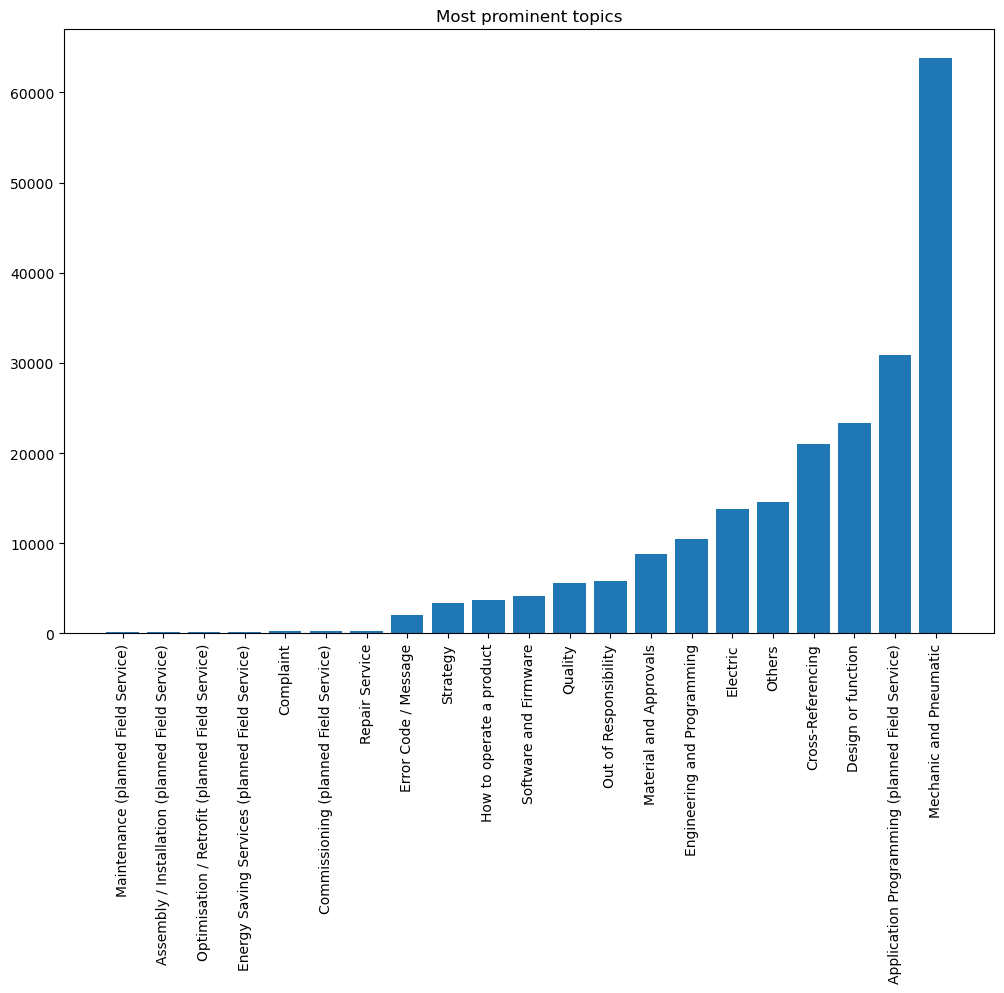

In [24]:
fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.bar(topic_counter_dict.keys(), topic_counter_dict.values())
plt.title("Most prominent topics")
plt.xticks(rotation = 90);

### Counting combination of topics

In [25]:
topic_combinations = pd.DataFrame()
topic_combinations_counter = defaultdict(int)

topic_combinations["sorted_topic_combis"] = working_df["clean_labels"].apply(lambda x: ", ".join(sorted(x)))
topic_combinations["combination_length"] = working_df["clean_labels"].apply(lambda x: len(x))

In [26]:
topic_combinations.head(), len(topic_combinations)

(                                 sorted_topic_combis  combination_length
 0                                 Design or function                   1
 1  Application Programming (planned Field Service...                   2
 2  Application Programming (planned Field Service...                   2
 3                             Mechanic and Pneumatic                   1
 4                                             Others                   1,
 188549)

In [27]:
combi_counts = dict(topic_combinations["sorted_topic_combis"].value_counts())


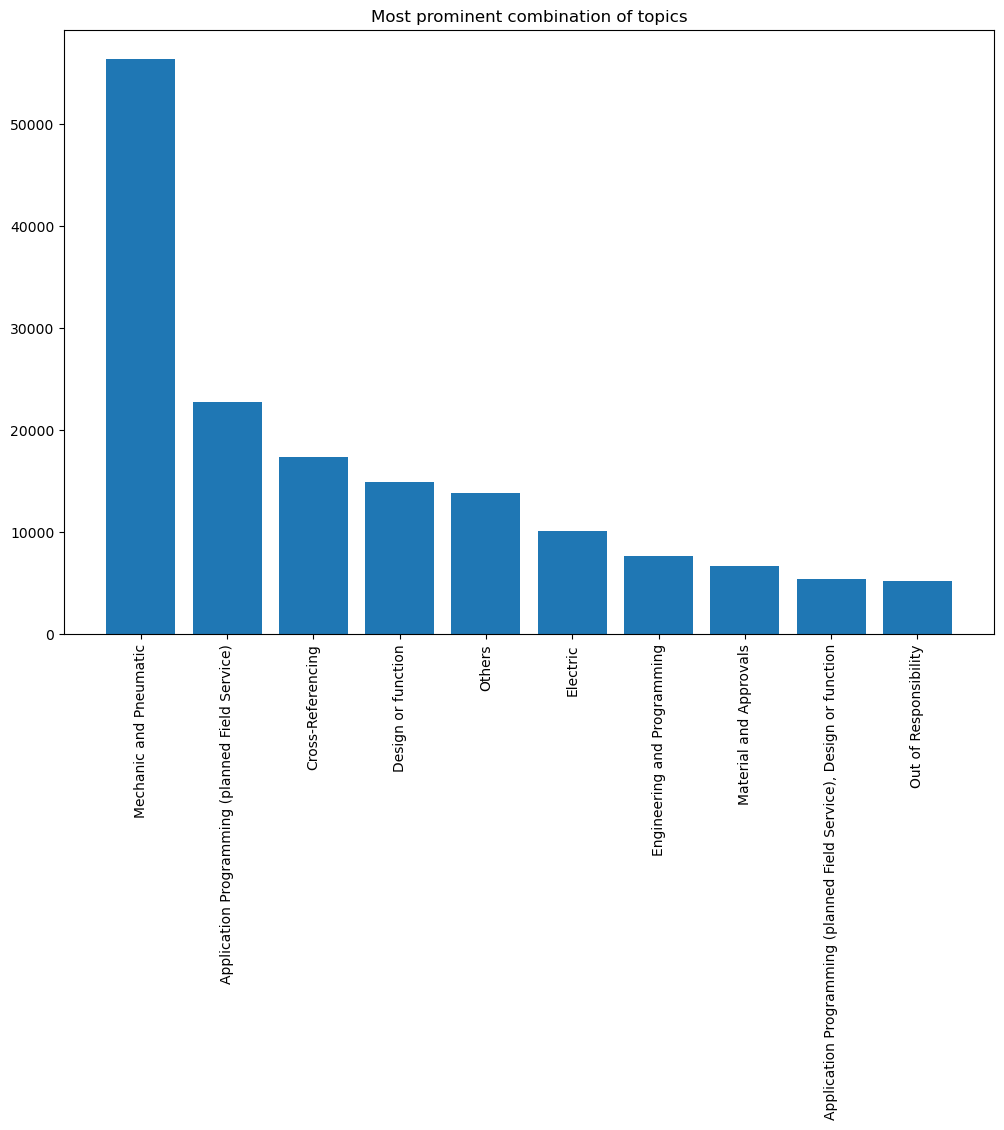

In [28]:
fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.bar(list(combi_counts.keys())[:10], list(combi_counts.values())[:10])
plt.title("Most prominent combination of topics")
plt.xticks(rotation = 90);

In [29]:
topic_combinations.head()

sorted_topic_combis  combination_length
0                                 Design or function                   1
1  Application Programming (planned Field Service...                   2
2  Application Programming (planned Field Service...                   2
3                             Mechanic and Pneumatic                   1
4                                             Others                   1

### Queries having multiple labels

In [30]:
labels_counter = {}
for x in range(len(working_df)):
    combi = len(working_df["clean_labels"][x])
    if combi not in labels_counter.keys():
        labels_counter[combi] = 1
    else:
        labels_counter[combi] += 1

Are there really labels with more than 10 topics? Indeed! :-o

In [31]:
labels_counter

{1: 169668,
 2: 16386,
 3: 2059,
 4: 200,
 8: 5,
 21: 111,
 5: 20,
 7: 4,
 9: 82,
 20: 7,
 19: 1,
 6: 6}

In [32]:
for x in range(len(working_df)):
    counter=0
    if len(working_df["clean_labels"][x]) > 20:
        print(x, working_df["clean_labels"][x])
        print(x, working_df["Kind of Question / Service"][x])
        counter += 1
        if counter == 5:
            break

1432 ['Application Programming (planned Field Service)', 'Cross-Referencing', 'Design or function', 'Software and Firmware', 'Error Code / Message', 'Out of Responsibility', 'How to operate a product', 'Material and Approvals', 'Others', 'Quality', 'Mechanic and Pneumatic', 'Material and Approvals', 'Strategy', 'Engineering and Programming', 'Engineering and Programming', 'Engineering and Programming', 'Software and Firmware', 'Electric', 'Mechanic and Pneumatic', 'Mechanic and Pneumatic', 'Material and Approvals']
1432 Application Programming (planned Field Service), Cross-Referencing, Design or function, Software and Firmware, Error Code / Message, Out of Responsibility, How to operate a product, Material and Approvals, Others, Quality, Mechanic and Pneumatic, Material and Approvals, Strategy, Engineering and Programming, Engineering and Programming, Engineering and Programming, Software and Firmware, Electric, Mechanic and Pneumatic, Mechanic and Pneumatic, Material and Approvals
14

In [33]:
labels_counter_sorted = sorted(labels_counter.items(), key=lambda x: x[1])
labels_counter_sorted_dict = dict(labels_counter_sorted)

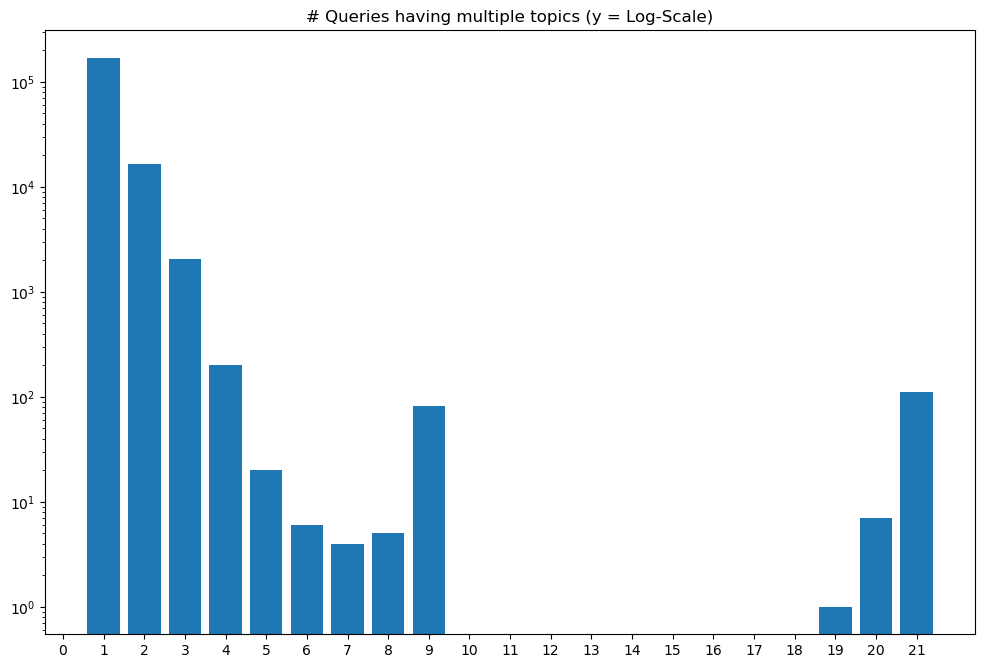

In [66]:
fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.bar(list(labels_counter_sorted_dict.keys()), list(labels_counter_sorted_dict.values()))
plt.title("# Queries having multiple topics (y = Log-Scale)")
plt.xticks(np.arange(0, 22, 1))
plt.yscale("log");

### Language counts

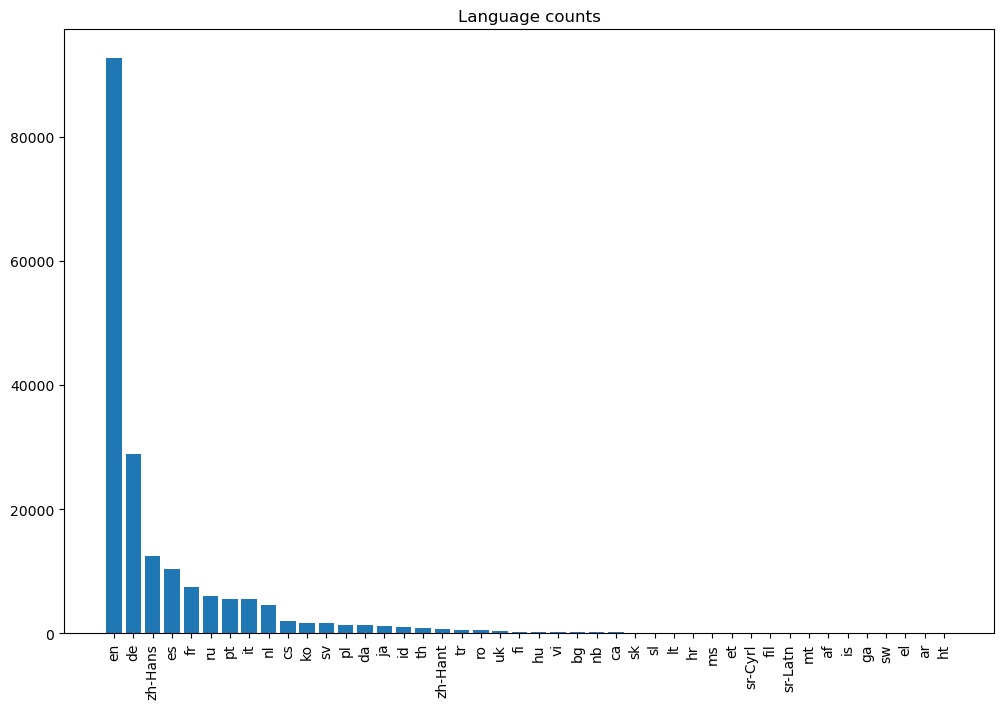

In [35]:
lang_counts = dict(working_df["Title_original_language"].value_counts())
fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.bar(lang_counts.keys(), lang_counts.values())
plt.title("Language counts")
plt.xticks(rotation = 90);

## One-hot Encoding of labels

In [36]:
topic_list, len(topic_list)

(['Design or function',
  'Application Programming (planned Field Service)',
  'Electric',
  'Mechanic and Pneumatic',
  'Others',
  'Software and Firmware',
  'Cross-Referencing',
  'Quality',
  'Engineering and Programming',
  'How to operate a product',
  'Strategy',
  'Material and Approvals',
  'Error Code / Message',
  'Out of Responsibility',
  'Commissioning (planned Field Service)',
  'Energy Saving Services (planned Field Service)',
  'Complaint',
  'Optimisation / Retrofit (planned Field Service)',
  'Repair Service',
  'Maintenance (planned Field Service)',
  'Assembly / Installation (planned Field Service)'],
 21)

In [37]:
#def one_hot_labels(df, label_column : str, topic_list):
#    for topic in topic_list:
#        for bla in range(len(working_df)):
#            if topic in df[label_column][bla]:
#                df[topic] = 1
#            else:
#                df[topic] = 0


In [38]:
# one_hot_labels(working_df, "clean_labels", topic_list)

In [39]:
mlb = MultiLabelBinarizer()
mlb.fit([topic_list])
mlb.classes_
# working_df.iloc[:10, 8:]

array(['Application Programming (planned Field Service)',
       'Assembly / Installation (planned Field Service)',
       'Commissioning (planned Field Service)', 'Complaint',
       'Cross-Referencing', 'Design or function', 'Electric',
       'Energy Saving Services (planned Field Service)',
       'Engineering and Programming', 'Error Code / Message',
       'How to operate a product', 'Maintenance (planned Field Service)',
       'Material and Approvals', 'Mechanic and Pneumatic',
       'Optimisation / Retrofit (planned Field Service)', 'Others',
       'Out of Responsibility', 'Quality', 'Repair Service',
       'Software and Firmware', 'Strategy'], dtype=object)

In [40]:
# Testing MultiLabelBinarizer
test_df = pd.DataFrame(working_df[:20])
test_df["labels_encoded"] = test_df["clean_labels"].apply(lambda x: mlb.transform([x]))
test_df.labels_encoded[:2], mlb.classes_[6], test_df["clean_labels"][1]

(0    [[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
 1    [[1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,...
 Name: labels_encoded, dtype: object,
 'Electric',
 ['Application Programming (planned Field Service)', 'Electric'])

In [41]:
working_df["labels_encoded"] = working_df["clean_labels"].apply(lambda x: mlb.transform([x]))

In [42]:
working_df["labels_encoded"].head(10)


0    [[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
1    [[1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,...
2    [[1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
3    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,...
4    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
5    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
6    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,...
7    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,...
8    [[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
9    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
Name: labels_encoded, dtype: object

## Spamreport detection

In [43]:
working_df["spamreport"] = working_df["Body"].apply(lambda x: 1 if re.search("Spamreport", x) else 0)

In [44]:
working_df["spamreport"].value_counts()

0    186149
1      2400
Name: spamreport, dtype: int64

In [45]:
print(working_df["Body"][working_df["spamreport"] == 1])

5         \n Spamreport\n[1] 01/02/2019 06:00 for [2]sup...
11        \n Spamreport\n[1] 01/02/2019 06:00 for [2]sup...
12        \n Spamreport\n[1] 01/02/2019 06:00 for [2]sup...
52        \n Spamreport\n[1] 01/02/2019 06:00 for [2]sup...
300       \n Spamreport\n[1] 31/01/2019 06:00 for [2]pro...
                                ...                        
188537    \n Spamreport\n[1] 01/01/2020 06:00 for [2]pro...
188538    \n Spamreport\n[1] 01/01/2020 06:00 for [2]tec...
188542    \n Spamreport\n[1] 01/01/2020 06:00 for [2]sup...
188545    \n Spamreport\n[1] 01/01/2020 06:00 for [2]sup...
188547    \n Spamreport\n[1] 01/01/2020 06:00 for [2]sup...
Name: Body, Length: 2400, dtype: object


In [46]:
working_df[:20]
print(working_df[working_df["spamreport"] == 1]["clean_labels"].value_counts())

[Others]                                                                                                                                                                       1403
[Out of Responsibility]                                                                                                                                                         411
[Quality]                                                                                                                                                                       129
[Application Programming (planned Field Service)]                                                                                                                               125
[Software and Firmware]                                                                                                                                                          96
[Cross-Referencing]                                                                                 

In [47]:
print(working_df[working_df["spamreport"] == 1]["Body"].iloc[200])


 Spamreport
[1] 03/01/2019 06:00 for [2]support_dk@festo.com

 													 														[3] 															Spam 													 											
	 														[4] 															soli_michelle@163.com 													 							
					 														[5] 															18:55 													 												 						
				

 													 														[6]RGBW / RGBWWW MIX COLOR STRIP 													 		
									 											

 													 														[7] 															Spam 													 											
	 														[8] 															info@sgon-fm.com 													 												
 														[9] 															11:30 													 												 											

 													 														[10]SS316 2PC Threaded Ball Valve--SGON VALVE 			
									 												 											

 													 														[11] 															Spam 													 										
		 														[12] 															wendy@universe-direct.co.za 													
													 														[13] 															10:34 													 										
	 

Interesting: Those spamreports have labels.
After inspection of those mails, we see there is barely any information included. Thus we will remove those mails from the dataset.

### Drop spamreport mails

In [48]:
working_df = working_df[working_df["spamreport"] == 0]

In [49]:
working_df.reset_index(drop = True)

TecReq#                                              Title  \
0       2019013111007824                                     VTUG 멀티핀 배선 문의   
1       2019013111007815          Part #571484 Current Consumption Question   
2       2019013111007806                         FW: Solenoid 5/2 Way Valve   
3       2019013111007799                                      Quote Request   
4       2019013111007781  New eMail - Fax-ID 25939900 ( 0020208066 - MOT...   
...                  ...                                                ...   
186144  2020010111000251  Spamreport from 01/01/2020 06:00 for complaint...   
186145  2020010111000232  Spamreport from 01/01/2020 06:00 for support.n...   
186146  2020010111000189                           Financiación no bancaria   
186147  2020010111000161  FW: Urgent 37005504 FID 30131751 FW: RFQ 900.0...   
186148  2020010111000143                               GCB valve conversion   

                               Kind of Question / Service  \
0                                      Design or function   
1       Application Programming (planned Field Service...   
2       Application Programming (planned Field Service...   
3                                  Mechanic and Pneumatic   
4                                                  Others   
...                                                   ...   
186144                                            Quality   
186145                                             Others   
186146                              Out of Responsibility   
186147                                  Cross-Referencing   
186148                                  Cross-Referencing   

       Title_original_language  \
0                           ko   
1                           en   
2                           en   
3                           en   
4                           en   
...                        ...   
186144                      en   
186145                      en   
186146                      es   
186147                      en   
186148                      en   

                                    Title_translated_text  \
0                              VTUG multi-pin wiring door   
1               Part #571484 Current Consumption Question   
2                              FW: Solenoid 5/2 Way Valve   
3                                           Quote Request   
4       New eMail - Fax-ID 25939900 ( 0020208066 - MOT...   
...                                                   ...   
186144  Spamreport from 01/01/2020 06:00 for complaint...   
186145  Spamreport from 01/01/2020 06:00 for support.n...   
186146                                 Non-bank financing   
186147  FW: Urgent 37005504 FID 30131751 FW: RFQ 900.0...   
186148                               GCB valve conversion   

                                                     Body  \
0                           VTUG 멀티핀 배선 문의\n\n요청자 : 영업 사원   
1       Hello Festo,\n\nI am looking at the datasheet ...   
2       Hello team,\n\ngood day!\n\nAny recommendation...   
3       Hello Product Support,\n\nPlease see the below...   
4       Hello Team,\n\nAre  you able to please assist ...   
...                                                   ...   
186144                                                  0   
186145                                                  0   
186146                                                  0   
186147  Dear Technical Support,\n\nQuotation needed   ...   
186148  Dear Festo member,\n\nGood day to you. Please ...   

       TypBezeichnung_lang1  \
0                       NaN   
1                       NaN   
2                       NaN   
3                       NaN   
4                       NaN   
...                     ...   
186144                  NaN   
186145                  NaN   
186146                  NaN   
186147               Others   
186148               Others   

                                             clean_labels  \
0                         

In [50]:
working_df["spamreport"].value_counts()

0    186149
Name: spamreport, dtype: int64

In [51]:
working_df.head()

TecReq#                                              Title  \
0  2019013111007824                                     VTUG 멀티핀 배선 문의   
1  2019013111007815          Part #571484 Current Consumption Question   
2  2019013111007806                         FW: Solenoid 5/2 Way Valve   
3  2019013111007799                                      Quote Request   
4  2019013111007781  New eMail - Fax-ID 25939900 ( 0020208066 - MOT...   

                          Kind of Question / Service Title_original_language  \
0                                 Design or function                      ko   
1  Application Programming (planned Field Service...                      en   
2  Application Programming (planned Field Service...                      en   
3                             Mechanic and Pneumatic                      en   
4                                             Others                      en   

                               Title_translated_text  \
0                         VTUG multi-pin wiring door   
1          Part #571484 Current Consumption Question   
2                         FW: Solenoid 5/2 Way Valve   
3                                      Quote Request   
4  New eMail - Fax-ID 25939900 ( 0020208066 - MOT...   

                                                Body TypBezeichnung_lang1  \
0                      VTUG 멀티핀 배선 문의\n\n요청자 : 영업 사원                  NaN   
1  Hello Festo,\n\nI am looking at the datasheet ...                  NaN   
2  Hello team,\n\ngood day!\n\nAny recommendation...                  NaN   
3  Hello Product Support,\n\nPlease see the below...                  NaN   
4  Hello Team,\n\nAre  you able to please assist ...                  NaN   

                                        clean_labels  \
0                               [Design or function]   
1  [Application Programming (planned Field Servic...   
2  [Application Programming (planned Field Servic...   
3                           [Mechanic and Pneumatic]   
4                                           [Others]   

                                      labels_encoded  spamreport  
0  [[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,...           0  
1  [[1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,...           0  
2  [[1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,...           0  
3  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,...           0  
4  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...           0

# First models without textprocessing
## Splitting dataset

In [52]:
len(working_df)

186149

In [53]:
y = []
working_df["labels_encoded"].apply(lambda x: y.append(x[0].tolist()))
y[:10], len(y)

([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
  [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
 186149)

In [54]:
X = working_df["Body"].tolist()
X[:10]


['VTUG 멀티핀 배선 문의\n\n요청자 : 영업 사원',
 'Hello Festo,\n\nI am looking at the datasheet on your website for part #571484 that we order from you, and cannot find information on the typical and max current consumption we should expect for this device. Can you please provide this information? We like to fuse all the power going to devices like these on our system, and I need that information to size the fuse. Please respond when you can.\n\nRegards,\n\nAndrew Hodges\nElectrical Engineer 1 | Etch Engineering\nDesk +1 510.572.7759 | Mobile +1 510.458.3558\n\nLam Research Corporation\n4650 Cushing Pkwy, Fremont, CA 94538 USA | www.lamresearch.com\nConnect with Lam Research: Facebook<https://www.facebook.com/LamResearchCorporation> | Twitter<https://twitter.com/lamresearch> | LinkedIn<https://www.linkedin.com/company/lam-research>\n\n________________________________\nCONFIDENTIAL - Limited Access and Use\n\nCONFIDENTIALITY NOTICE: This e-mail transmission, and any documents, files, or previous e-ma

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size=0.2, shuffle=True)

## Support Vector Classifier

In [56]:
sv_clf = Pipeline([
    ("tfidf", TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,1), norm='l2')),
    ("sv", OneVsRestClassifier(LinearSVC()))])


In [57]:
sv_clf.fit(X_train, y_train)


Pipeline(steps=[('tfidf', TfidfVectorizer(strip_accents='unicode')),
                ('sv', OneVsRestClassifier(estimator=LinearSVC()))])

In [58]:
pred = sv_clf.predict(X_test)

In [59]:
pred[:5], y_train[:5]

(array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]),
 [[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [60]:
pred_labels = mlb.inverse_transform(pred[:5])
pred_labels

[('Mechanic and Pneumatic',),
 (),
 ('Design or function',),
 ('Electric', 'Mechanic and Pneumatic', 'Software and Firmware'),
 ()]

### SVC metrics

In [62]:
multilabel_metrics(y_test, pred)

Exact Match Ratio: 0.31114692452323395
Hamming loss: 0.046118721461187215
I/O Loss: 0.688853075476766
Label ranking average precision: 0.3719778170018876


## LogReg-Classifier

In [64]:
logreg_clf = Pipeline ([
    ("tfidf", TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,3), norm='l2')),
    ("logreg", OneVsRestClassifier(LogisticRegression()))
])

In [65]:
# logreg_clf.fit(X_train, y_train)